In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import pandas as pd
from loguru import logger
import csv
import re

from OpenBookkeeping.sql_db import query_by_col, update_by_col, add_detail, del_by_col, query_table, query_by_str
from OpenBookkeeping.cash_flow import EqualDelt, InterestLoan, FinishLoan, EqualPrincipalPayment
from OpenBookkeeping.gloab_info import prop_type_items, liability_currency_types

In [2]:
db_path = "E:\\nextcloud\\use.bk"

query_str = """
        select type, name, start_date, term_month, rate, currency, ctype, sum(amount) from prop 
        LEFT outer join prop_details
        on prop.id = prop_details.target_id group by name;
        """

In [3]:
props = query_by_str(db_path, query_str)

2024-01-23 17:16:05.292 | DEBUG    | OpenBookkeeping.sql_db:query_by_str:137 - sql_str='\n        select type, name, start_date, term_month, rate, currency, ctype, sum(amount) from prop \n        LEFT outer join prop_details\n        on prop.id = prop_details.target_id group by name;\n        '


In [4]:
prop_df = pd.DataFrame(props, columns=['type', 'name', 'start_date', 'term_month', 'rate', 'currency', 'ctype', 'sum_amount'])
prop_df.fillna(0, inplace=True)
prop_df['type_cn'] = prop_df['type'].apply(lambda x: prop_type_items[x])

In [5]:
groups = prop_df[['name','type_cn', 'sum_amount']].groupby('type_cn')
for g in groups:
    print(g)

('固定资产',     name type_cn  sum_amount
0  2B801    固定资产   5000000.0
1  42001    固定资产   7500000.0
5   何-工资    固定资产         0.0
6   姜-工资    固定资产         0.0
8   对外债权    固定资产     15600.0)
('流动资产',        name type_cn  sum_amount
4     中行-活期    流动资产       105.0
11    建行-活期    流动资产      6609.0
15  建行对公-活期    流动资产      2580.0
17    招行-活期    流动资产      5255.0
19    支付宝基金    流动资产     10370.0)
('短期负债',         name type_cn  sum_amount
2     jy-园丁贷    短期负债         0.0
3   jy-建行消费贷    短期负债         0.0
10    建行-抵押贷    短期负债   1560000.0
12    建行-消费贷    短期负债         0.0
16    招行-信用卡    短期负债         0.0
18    招行-消费贷    短期负债    200000.0
20    浦发-信用卡    短期负债         0.0)
('长期负债',          name type_cn  sum_amount
7       姜家备用金    长期负债         0.0
9    工行2001房贷    长期负债   2530000.0
13  建行801公积金贷    长期负债    400000.0
14    建行801房贷    长期负债    616551.0
21        生活费    长期负债         0.0)


In [6]:
as_amount = np.sum(prop_df[prop_df['type'] <= 1]['sum_amount'])
de_amount = np.sum(prop_df[prop_df['type'] >= 2]['sum_amount'])
ne_amount = as_amount - de_amount
cash = np.sum(prop_df[prop_df['type'] == 1]['sum_amount'])
print(f'资产:{as_amount/10000}万, 负债{de_amount/10000}万，净值{ne_amount/10000}万, 现金{cash/10000}万')

资产:1254.0519万, 负债530.6551万，净值723.3968万, 现金2.4919万


In [7]:
from datetime import datetime

detail_str = """
select type, name, occur_date, amount 
from prop LEFT outer join prop_details on prop.id = prop_details.target_id;
"""
prop_details = query_by_str(db_path, detail_str)
prop_detail_df =  pd.DataFrame(prop_details, columns=['type', 'name', 'occur_date',  'amount'])
prop_detail_df.dropna(inplace=True)

prop_detail_df['o_date'] = prop_detail_df['occur_date'].apply(lambda \
      x: datetime.strptime(x,'%Y-%m-%d').date())

2024-01-23 17:16:05.355 | DEBUG    | OpenBookkeeping.sql_db:query_by_str:137 - sql_str='\nselect type, name, occur_date, amount \nfrom prop LEFT outer join prop_details on prop.id = prop_details.target_id;\n'


In [8]:
prop_detail_df.head()

,type,name,occur_date,amount,o_date
0,0,2B801,2014-09-30,5000000.0,2014-09-30
1,0,42001,2019-04-30,7500000.0,2019-04-30
4,1,招行-活期,2022-01-01,8800.0,2022-01-01
5,1,招行-活期,2022-04-20,1900.0,2022-04-20
6,1,招行-活期,2022-04-20,3786.0,2022-04-20


In [9]:
from dateutil.relativedelta import relativedelta
from collections import defaultdict

td = relativedelta(months=1, day=1)
next_month_first_day = datetime.today().date() + td

per_month_rec = []
for i in range(-24, 1, 1):
    end_date = next_month_first_day + relativedelta(months=i, day=1)
    end_df = prop_detail_df[prop_detail_df['o_date'] < end_date]
    prop_sum = np.sum(end_df[end_df['type'] <= 1]['amount'])
    det_sum = np.sum(end_df[end_df['type'] > 1]['amount'])
    net_sum = prop_sum - det_sum
    per_month_rec.append({'odate': end_date, 'prop': prop_sum/10000, 'det': det_sum/10000, 'net': net_sum/10000})
per_month_df = pd.DataFrame(per_month_rec)

In [10]:
per_month_df.tail()

,odate,prop,det,net
20,2023-10-01,1253.5787,530.6000,722.9787
21,2023-11-01,1254.1125,530.6000,723.5125
22,2023-12-01,1253.6836,527.6000,726.0836
23,2024-01-01,1253.6836,527.6000,726.0836
24,2024-02-01,1254.0519,530.6551,723.3968


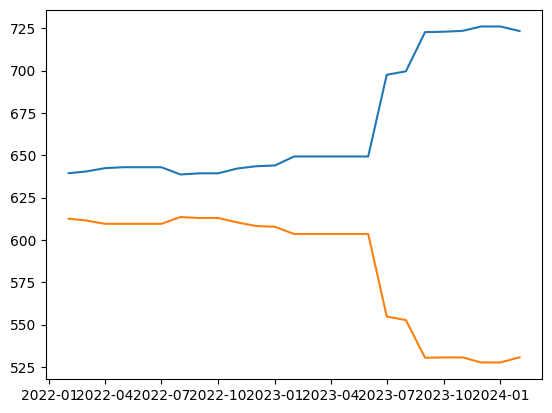

In [11]:
plt.plot(per_month_df['odate'], per_month_df['net'])
plt.plot(per_month_df['odate'], per_month_df['det'])

In [12]:
udf = prop_df[(prop_df['sum_amount'] != 0) | (prop_df['currency'] != 0)]
udf

,type,name,start_date,term_month,rate,currency,ctype,sum_amount,type_cn
0,0,2B801,2023-06-01,0,0.0,5300,0,5000000.0,固定资产
1,0,42001,2023-06-01,0,0.0,0,0,7500000.0,固定资产
4,1,中行-活期,2023-06-01,0,0.0,0,0,105.0,流动资产
5,0,何-工资,2023-06-01,0,0.0,25000,0,0.0,固定资产
6,0,姜-工资,2023-06-01,0,0.0,20000,0,0.0,固定资产
8,0,对外债权,2023-06-01,0,0.0,0,0,15600.0,固定资产
9,2,工行2001房贷,2019-04-28,360,4.3,0,1,2530000.0,长期负债
10,3,建行-抵押贷,2022-12-20,36,3.9,0,2,1560000.0,短期负债
11,1,建行-活期,2023-06-01,0,0.0,0,0,6609.0,流动资产
13,2,建行801公积金贷,2014-10-03,360,3.0,0,1,400000.0,长期负债


In [21]:
today = datetime.today().date()
all_df = []
show_term = 36

for idx, row in udf.iterrows():
    if row['ctype'] in {1, 3}:
        start_date = datetime.strptime(row['start_date'],'%Y-%m-%d').date()
        loan = EqualDelt(row['sum_amount'], row['rate'], start_date, today, row['term_month'], row['ctype'])
    elif row['ctype'] == 0:
        loan = EqualPrincipalPayment(row['currency'], today, show_term)
    elif row['ctype'] == 2:
        start_date = datetime.strptime(row['start_date'],'%Y-%m-%d').date()
        loan = InterestLoan(row['sum_amount'], row['rate'], start_date, today, row['term_month'])
    elif row['ctype'] == 4:
        loan = FinishLoan(row['sum_amount'], row['rate'], today, row['term_month'])
    else:
        raise ValueError(f'ctype error, {row=}')
    schedule = loan.schedule()
    schedule['name'] = row['name']
    schedule['type'] = row['type']
    all_df.append(schedule)    

In [22]:
all_pred = pd.concat(all_df)
all_pred.to_csv('d.csv')
all_date = sorted(list(set(all_pred['date'])))
# ne_amount = as_amount - de_amount
current_net = as_amount - de_amount
current_cash = cash
all_c = []
for day in all_date[:show_term]:
    recs = all_pred[all_pred['date'] == day]
    # 权益增加，现金增加
    prop_add = 0
    cash_add = 0
    detail_str = ''
    for idx, row in recs.iterrows():
        # print(row)
        if row['payment'] == 0:
            continue
        detail_str += f"{row['name']}:{round(row['payment'])},"
        if row['type'] <= 1:
            prop_add += row['interest']
            cash_add += row['payment']
        else:
            prop_add -= row['interest']
            cash_add -= row['payment']
    current_net += prop_add
    current_cash += cash_add
    rec = {'date': day, 'prop_add': prop_add, 'cash_add': cash_add, 'current_net': current_net, 'current_cash': current_cash, 'detail': detail_str}
    all_c.append(rec)

cash_predict = pd.DataFrame(all_c)
cash_predict.to_csv('predict.csv')